# SENTIMENT ANALYSIS ON TWEETS

In [2]:
# Data Manipulation
import pandas as pd
import numpy as np
import re

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# NLP
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


##Load Dataset

dataset : https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment

In [3]:
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/dataset.csv")
df.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


## Select Columns

In [4]:
df = df[['text','airline_sentiment']]

# Map sentiments to numbers (0 = negative, 1 = positive)
df = df[df['airline_sentiment'] != 'neutral']
df['target'] = df['airline_sentiment'].map({'negative':0, 'positive':1})

df.head()


,text,airline_sentiment,target
1,@VirginAmerica plus you've added commercials t...,positive,1
3,@VirginAmerica it's really aggressive to blast...,negative,0
4,@VirginAmerica and it's a really big bad thing...,negative,0
5,@VirginAmerica seriously would pay $30 a fligh...,negative,0
6,"@VirginAmerica yes, nearly every time I fly VX...",positive,1


## Data Cleaning

In [5]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)        # remove URLs
    text = re.sub(r'@\w+', '', text)           # remove mentions
    text = re.sub(r'#', '', text)              # remove hashtags
    text = re.sub(r'[^a-z\s]', '', text)       # remove punctuation/numbers
    return text

df['clean_text'] = df['text'].apply(clean_text)
df[['text','clean_text']].head()


,text,clean_text
1,@VirginAmerica plus you've added commercials t...,plus youve added commercials to the experienc...
3,@VirginAmerica it's really aggressive to blast...,its really aggressive to blast obnoxious ente...
4,@VirginAmerica and it's a really big bad thing...,and its a really big bad thing about it
5,@VirginAmerica seriously would pay $30 a fligh...,seriously would pay a flight for seats that ...
6,"@VirginAmerica yes, nearly every time I fly VX...",yes nearly every time i fly vx this ear worm ...


## NLP Preprocessing

In [6]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

df['processed_text'] = df['clean_text'].apply(preprocess)
df[['clean_text','processed_text']].head()


,clean_text,processed_text
1,plus youve added commercials to the experienc...,plus youve added commercial experience tacky
3,its really aggressive to blast obnoxious ente...,really aggressive blast obnoxious entertainmen...
4,and its a really big bad thing about it,really big bad thing
5,seriously would pay a flight for seats that ...,seriously would pay flight seat didnt playing ...
6,yes nearly every time i fly vx this ear worm ...,yes nearly every time fly vx ear worm wont go ...


## Visualization

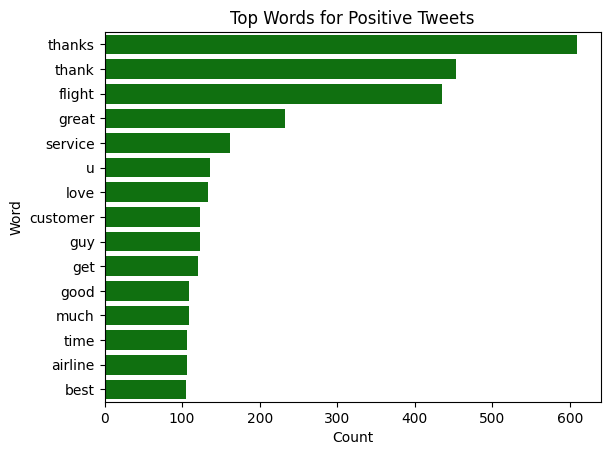

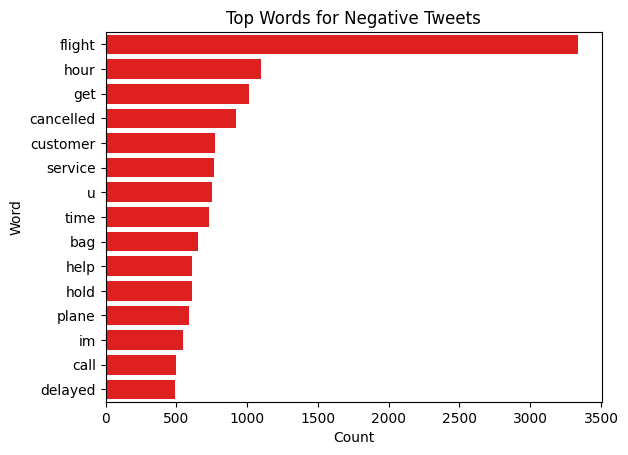

In [7]:
# 🔹 STEP 6: Bar Charts of Most Frequent Words
def plot_top_words(data, label, color):
    words = " ".join(df[df['target']==label]['processed_text']).split()
    freq = Counter(words).most_common(15)

    sns.barplot(x=[count for word,count in freq],
                y=[word for word,count in freq],
                color=color)
    plt.title(f"Top Words for {'Positive' if label==1 else 'Negative'} Tweets")
    plt.xlabel("Count")
    plt.ylabel("Word")
    plt.show()

plot_top_words(df, label=1, color="green")   # positive
plot_top_words(df, label=0, color="red")     # negative


## Feature Extraction

In [8]:
X = df['processed_text']
y = df['target']

tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)


## Training the Model

In [9]:
# 🔹 STEP 8: Train Model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


## Evaluate the Model

Accuracy: 0.8969250757903855

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.98      0.94      1862
           1       0.89      0.53      0.67       447

    accuracy                           0.90      2309
   macro avg       0.90      0.76      0.80      2309
weighted avg       0.90      0.90      0.89      2309



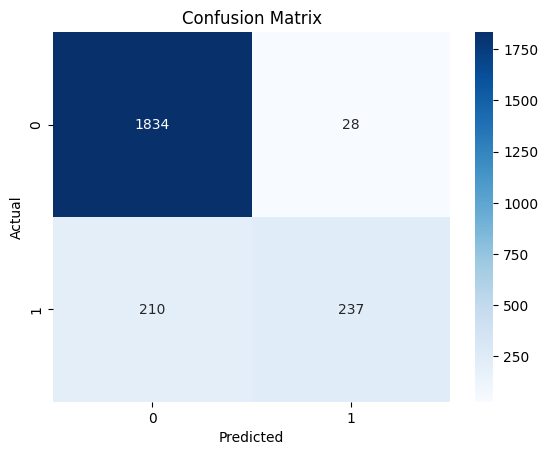

In [10]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


## Test

In [11]:
# Test on Custom Input
sample = ["I love this airline, the service is amazing!",
          "This was the worst flight experience ever."]

sample_tfidf = tfidf.transform(sample)
print(model.predict(sample_tfidf))  # 1 = positive, 0 = negative


[1 0]
